<a href="https://colab.research.google.com/github/wjh818/Data_hwj/blob/main/Deep_Learning/11_Tensorflow_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow로 모델링 하는 2가지 방법

* Sequential 모델링을 활용하는 방법
 * keras에서 제공하는 레이어들을 이어 붙여 가면서 모델링 하는 방법
 * 쉽고 빠르게 모델링이 가능
 * 커스터마이징이 조금 힘들다

* Functional API를 활용하는 방법
 * 개발자가 직접 레이어를 정의해서 keras의 레이어 처럼 사용하게 할 수 있다.(`tf.keras.layers 상속`)
 * 기타 평가 방식이나 Loss, Optimizer 등등을 직접 정의해서 사용할 수 있다.



# tf.data 사용하기
* 일반적인 배열이 아닌, 병렬 처리된 배열을 이용하여 매우 빠른 속도로 데이터의 입출력이 가능
* dataset 이라는 개념을 이용해서 feature, label을 손쉽게 관리 할 수 있다.

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets

In [26]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[..., tf.newaxis]
X_test  = X_test[..., tf.newaxis]

X_train, X_test = X_train / 255.0, X_test / 255.0

## tf.data의 함수들
* `from_tensor_slices()` : feature, label을 합친 데이터세트(ds)를 생성
* `shuffle()` : 데이터세트에 들어있는 데이터를 랜덤하게 섞음
* `batch()` : 배치 생성하기

In [27]:
# 제너레이트할 데이터를 넣어준다. 데이터를 병렬로 처리할 수 있다. ( 속도가 매우 빨라짐 )
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# 데이터 섞기
train_ds = train_ds.shuffle(1000) # 매개 변수 숫자는 랜덤 시드가 아닌 랜덤을 생성하기 위한 버퍼 사이즈( 보통 1kb 정도로 설정 )

# 배치 생성
train_ds = train_ds.batch(32) # iteration 할 때마다 batch_size만큼 데이터가 나온다.

In [28]:
# 테스트 ds 만들기
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# 테스트 세트는 셔플이 필요 없다.
test_ds = test_ds.batch(32)

## tf.data로 만든 데이터세트의 시각화

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

`take()` 함수를 이용하면 데이터를 배치 사이즈만큼 가지고 올 수 있다.

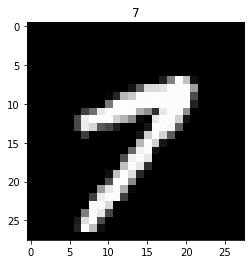

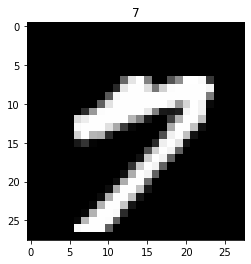

In [30]:
for images, labels in train_ds.take(2):
  image = images[0, ..., 0]
  label = labels.numpy()[0]

  plt.title(label)
  plt.imshow(image, 'gray')
  plt.show()

## tf.data를 이용한 CNN 모델 훈련

In [31]:
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import Dropout, Flatten, Dense

input_shape = ( 28, 28, 1 )
num_classes = 10

inputs = layers.Input(shape=input_shape)

# Feature Extraction
net = Conv2D(32, 3, padding='SAME')(inputs)
net = Activation("relu")(net)
net = Conv2D(32, 3, padding='SAME')(net)
net = Activation("relu")(net)
net = MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)

net = Conv2D(64, 3, padding='SAME')(net)
net = Activation("relu")(net)
net = Conv2D(64, 3, padding='SAME')(net)
net = Activation("relu")(net)
net = MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)

# Fully Connected
net = Flatten()(net)
net = Dense(512)(net)
net = Activation("relu")(net)
net = Dropout(0.25)(net)

# Output Layer
net = Dense(num_classes)(net)
net = Activation("softmax")(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [32]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [33]:
# tf.data를 이용해서 훈련
model.fit(train_ds, epochs=1) # train_ds에는 feature, label, batch 정보가 모두 들어있다.

1875/1875 [==============================] - 7s 4ms/step - loss: 0.2924


# Functional API 사용해 보기

Loss Function이나 Optimizer 등을 Tensorflow 및 Keras에서 제공하는 것이 아닌, 개발자가 직접 함수를 만들어서 사용할 때 커스터마이징하기 위한 방법

In [34]:
# Loss Function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Optimizer
optimizer = tf.keras.optimizers.Adam()

In [35]:
train_loss = tf.keras.metrics.Mean(name="train_loss") # 각 배치에 대한 평가 결과를 평균으로 관리
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## @tf.function
Functional API에서 제일 많이 사용되는 어노테이션으로써, Tensorflow 세션에서 관리하는 함수가 될 수 있도록 해준다.

`@tf.function`이 붙은 함수는 계산그래프가 모두 그려지고 실제 학습 되면서 수행되기 때문에, Tensorflow의 리소스를 이용할 수 있게 된다.

보통 학습 및 테스트하는 함수에 붙는다.

In [36]:
@tf.function
def train_step(images, labels):

  # 자동 미분 수행을 위한 환경 만들기
  # loss 구하는 과정
  with tf.GradientTape() as tape:
    # 1. 예측
    prediction = model(images) # 모델이 훈련 모드가 된다.

    # 2. loss 구하기
    loss = loss_object(labels, prediction)
  
  # 3. 오차 역전파 수행 (gradients : 수정 되어야할 기울기 벡터)
  gradients = tape.gradient(loss, model.trainable_variables)# model.trainable_variables : 가중치, 편향 정보 (수정가능한...)

  # 4. 최적화 (apply_gradients : 매개변수 업데이트)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # loss, accuracy를 기록
  train_loss(loss)
  train_accuracy(labels, prediction)

In [37]:
@tf.function
def test_step(images, labels):
  prediction = model(images)
  t_loss = loss_object(labels, prediction)

  test_loss(t_loss)
  test_accuracy(labels, prediction)

In [38]:
# Functional API 방식으로 훈련

epochs = 10

for epoch in range(epochs):

  # 1 에폭은 모든 데이터에 대한 학습
  for images, labels in train_ds:
    train_step(images, labels)
  
  # 테스트 수행
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss : {:.3f}, Accuracy: {:.3f}, Test Loss : {:.3f}, Test Accuracy: {:.3f}'
  print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100))

Epoch 1, Loss : 0.041, Accuracy: 98.775, Test Loss : 0.033, Test Accuracy: 98.950
Epoch 2, Loss : 0.033, Accuracy: 99.002, Test Loss : 0.032, Test Accuracy: 98.975
Epoch 3, Loss : 0.028, Accuracy: 99.144, Test Loss : 0.030, Test Accuracy: 99.043
Epoch 4, Loss : 0.024, Accuracy: 99.264, Test Loss : 0.030, Test Accuracy: 99.037
Epoch 5, Loss : 0.022, Accuracy: 99.335, Test Loss : 0.031, Test Accuracy: 99.044
Epoch 6, Loss : 0.020, Accuracy: 99.403, Test Loss : 0.032, Test Accuracy: 99.053
Epoch 7, Loss : 0.018, Accuracy: 99.455, Test Loss : 0.032, Test Accuracy: 99.081
Epoch 8, Loss : 0.017, Accuracy: 99.483, Test Loss : 0.033, Test Accuracy: 99.090
Epoch 9, Loss : 0.016, Accuracy: 99.515, Test Loss : 0.033, Test Accuracy: 99.102
Epoch 10, Loss : 0.015, Accuracy: 99.547, Test Loss : 0.034, Test Accuracy: 99.107
